In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
small_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
       description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax', route it to 'llm'.
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", '{query}'),
])

structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState):
  query = state['query']
  router_chain = router_prompt | structured_router_llm
  route = router_chain.invoke({'query': query})
  print(f"Routing to: {route}")
  return route.target

In [ ]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState):
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

In [6]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>
  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. 
[개정 2014. 1. 1.]
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제2절 세액의 계산 <개정 2009. 12. 31.>
제1관 세율 <개정 2009. 12. 31.>
제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>
종합소득
┌───────────────┐
│ 과세표준의 6개 구간 │
├───────────────┤
│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │
│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하는 금액의 24%)

e:\jwy\learn-ai-tools\langGraph\real_estate_tax_graph.py:113: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


[{'title': '부동산] 정부, 2026년 공동주택 공시가격 현실화율 69%로 동결', 'url': 'http://www.areyou.co.kr/news/articleView.html?idxno=91503', 'content': '������ ��Ÿ���� �����̴�.  ���� ������ ���� ���� ����ȭ���� 2020�� �������� ���� ���������� ���ε��� ���ݰ��ÿ� ���� ����(�ε��갡�ݰ��ù�)�� �\uefe1 ���� ����ȭ ��ȹ�� �����ǰ� �ִ�.  �����δ� �ε��� ���ð��� ����ȭ ��ȹ�� �⺻���� Ʋ�� �����ϵ�, ������ �ü��ݿ��� ��ǥ ���� ���� ���� ���� ������ ���� ���� �����Ѵٴ� ��ȹ�̴�. Ư�� ���俬������ ���翡 ������ ������ �� 61% �̻��� ���ð����� ������ Ȯ���� �߿��ϴٴ� �ν��� ���� �ִ� ��ŭ, ���״뺰 ��ǥ �ü��ݿ����� �߽����� �ü��ݿ����� ������ �ؼ��ϴ� �� �������� ������ ���� ��ħ�̴�.  ���ð��� �����������\u0378� ���� ���������� ����ü�� ����, �������� ���� �ΰ�����(AI) ���� �������� Ȱ��, �ʰ������� ������ ���� ���� ���� �ü��� ��Ȯ���� �������� ���δ�.  �̹� �������ȿ� ���� �����Ǵ� 2026�� ���� ���ð����� ǥ������ǥ�������� ���� 2026�� 1��, ���������� ���� �� 4�� ���� ������ �����̴�.  ������ ������ “���� 67�� ������ [...] ����   ������ ����  ���� 2025.11.14 15:03   �۾�Ű����;)

In [7]:
from langgraph.graph import START,END

graph_builder.add_conditional_edges(
  START,
  router,
  {
    'income_tax': 'income_tax',
    'real_estate_tax': 'real_estate_tax',
    'llm': 'llm',
  }
)

graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [8]:
graph = graph_builder.compile()

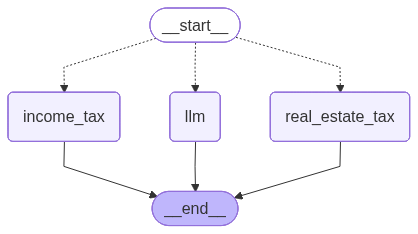

In [9]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
initial_state = {'query' : '집 15억은 세금을 얼마나 내나요?'}

graph.invoke(initial_state)

Routing to: target='real_estate_tax'
[{'title': '부동산] 정부, 2026년 공동주택 공시가격 현실화율 69%로 동결', 'url': 'http://www.areyou.co.kr/news/articleView.html?idxno=91503', 'content': '������ ��Ÿ���� �����̴�.  ���� ������ ���� ���� ����ȭ���� 2020�� �������� ���� ���������� ���ε��� ���ݰ��ÿ� ���� ����(�ε��갡�ݰ��ù�)�� �\uefe1 ���� ����ȭ ��ȹ�� �����ǰ� �ִ�.  �����δ� �ε��� ���ð��� ����ȭ ��ȹ�� �⺻���� Ʋ�� �����ϵ�, ������ �ü��ݿ��� ��ǥ ���� ���� ���� ���� ������ ���� ���� �����Ѵٴ� ��ȹ�̴�. Ư�� ���俬������ ���翡 ������ ������ �� 61% �̻��� ���ð����� ������ Ȯ���� �߿��ϴٴ� �ν��� ���� �ִ� ��ŭ, ���״뺰 ��ǥ �ü��ݿ����� �߽����� �ü��ݿ����� ������ �ؼ��ϴ� �� �������� ������ ���� ��ħ�̴�.  ���ð��� �����������\u0378� ���� ���������� ����ü�� ����, �������� ���� �ΰ�����(AI) ���� �������� Ȱ��, �ʰ������� ������ ���� ���� ���� �ü��� ��Ȯ���� �������� ���δ�.  �̹� �������ȿ� ���� �����Ǵ� 2026�� ���� ���ð����� ǥ������ǥ�������� ���� 2026�� 1��, ���������� ���� �� 4�� ���� ������ �����̴�.  ������ ������ “���� 67�� ������ [...] ����   ������ ���

In [ ]:
initial_state = {'query' : '떡볶이는 어디가 맛있나요?'}

graph.invoke(initial_state)